In [3]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

import numpy as np
import cv2 as cv
from cake import cake
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from scipy import signal
from scipy.spatial.transform import Rotation as R
from cluster_half_shelfs_alpha import Half_shelf_cluster
from cluster_to_edge_pixel import contour_edge
from confectionery import Confectionery
from utitlity_functions import *
from scipy.spatial.transform import Rotation as R
import matplotlib as mpl
from matplotlib import cm
from particle_data_structure import ParticleDataStruct
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 11,
    'text.usetex': True,
})
import matplotlib.patches as mpatches
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal


np.random.seed(137)

In [4]:
folder_name="Gute_aufnahme_shortened"


In [5]:
data_paths=os.listdir(os.path.join("../data",folder_name))
stream_string=np.load(os.path.join("../data",folder_name,"image_paths_smooth.npy"))
objs=[x for x in data_paths if "pos_data" in x]
objs_number=np.array([int(x[9:-4]) for x in objs])
indexing=np.argsort(objs_number)
objs=[np.load(os.path.join("../data",folder_name,objs[x])) for x in indexing]
number_objs=len(objs)

koppenrath=Confectionery()

destination_normal_vector_traj=os.path.join("../data",folder_name,"normal_vector_trajectory_")
destination_rotation_traj_as_rotvec=os.path.join("../data",folder_name,"rotation_trajectory_as_rotvec_")

particle_structured3d_path=os.path.join("../data",folder_name,"particle_structured3d_")
particle_structured_flat_path=os.path.join("../data",folder_name,"particle_structured_flat_")

In [6]:
cut_radius=[int(np.floor(np.mean(x[:,-1])))-1 for x in objs]
structured_datas=[ParticleDataStruct(x,stream_string,c,koppenrath) for x,c in zip(objs,cut_radius)]
particle_datas_3d=[np.load(particle_structured3d_path+str(i)+".npy")for i in range(number_objs)]
particle_datas_flat=[np.load(particle_structured_flat_path+str(i)+".npy") for i in range(number_objs)]
particle_datas_flat_effective=[x.get_data_flatten_effective(c,y) for x,y,c in zip(structured_datas,particle_datas_flat,cut_radius)]

In [7]:
half_shelf_clusters=[Half_shelf_cluster(objs, stream_string, confectionery=koppenrath,cut_radius=c) for x,c in zip(objs,cut_radius)]
priors=[]
means=[]
variance=[]
labels=[]
avg_likelihood=[]
datas=[]
for i in range(number_objs):
    half_shelf_clusters[i].load_data_from_np_array(particle_datas_flat_effective[i].flatten())
    pi,l = half_shelf_clusters[i].train_gmm()
    datas.append(particle_datas_flat_effective[i].flatten())
    priors.append(pi)
    means.append(half_shelf_clusters[i].means_gmm)
    variance.append(half_shelf_clusters[i].variance)
    avg_likelihood.append(l)



In [8]:
def solve_gaussian_intersection(priors,means,std):
    a = 1/(2*std[0]**2) - 1/(2*std[1]**2)
    b = means[1]/(std[1]**2) - means[0]/(std[0]**2)
    c = (means[0]**2 /(2*std[0]**2) - means[1]**2 / (2*std[1]**2) - np.log(std[1]/std[0]))-np.log(priors[0]/priors[1])
    roots=np.roots([a,b,c])
    if roots[0]>=np.min(means) and roots[0]<=np.max(means):
        roots_1=roots[0]
        roots_2=roots[1]
    else:
        roots_1=roots[1]
        roots_2=roots[0]
    return roots_1,roots_2

In [10]:
print(priors)
print(means[0])
print(variance[0])
print(datas)
print(avg_likelihood[7])
print(avg_likelihood[9])
print(np.exp(np.array(avg_likelihood)))
print(np.mean(np.array(priors),axis=0))

[array([0.3143943, 0.6856057]), array([0.45554737, 0.54445263]), array([0.68190732, 0.31809268]), array([0.59470515, 0.40529485]), array([0.73532484, 0.26467516]), array([0.48551318, 0.51448682]), array([0.50915841, 0.49084159]), array([0.7364285, 0.2635715]), array([0.44782332, 0.55217668]), array([0.535442, 0.464558]), array([0.57805355, 0.42194645]), array([0.60581023, 0.39418977]), array([0.60211378, 0.39788622]), array([0.37106284, 0.62893716]), array([0.25922249, 0.74077751])]
[ 98.09160349 106.56913981]
[ 2.24578686 12.17727266]
[array([106.87501, 108.9375 , 108.875  , ..., 102.1875 , 102.     ,
       103.6875 ], dtype=float32), array([110.0625 , 108.56251, 108.0625 , ..., 110.1875 , 111.75   ,
       105.5625 ], dtype=float32), array([102.9375 , 105.25   , 104.87501, ..., 101.50001, 101.3125 ,
       101.8125 ], dtype=float32), array([112.9375 , 114.25   , 112.68751, ..., 101.25   , 101.25   ,
       104.375  ], dtype=float32), array([104.9375,  99.875 ,  99.9375, ..., 117.937

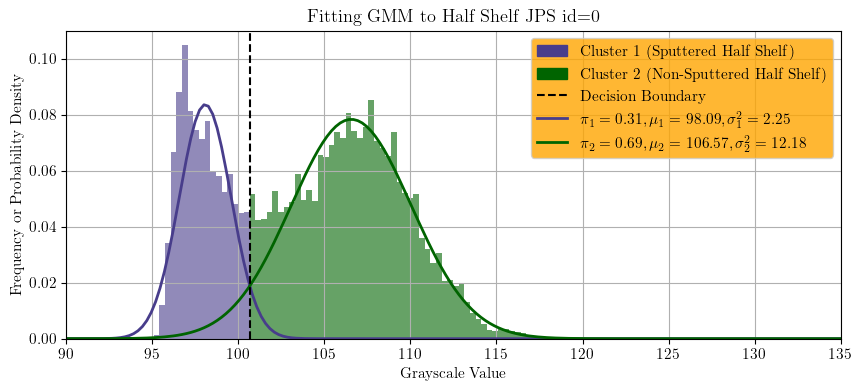

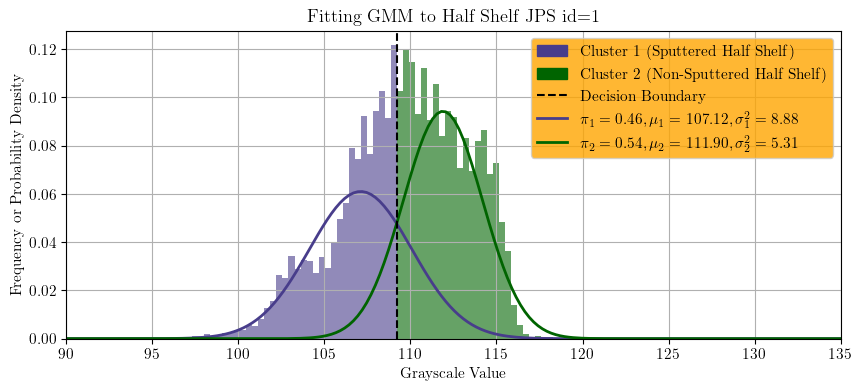

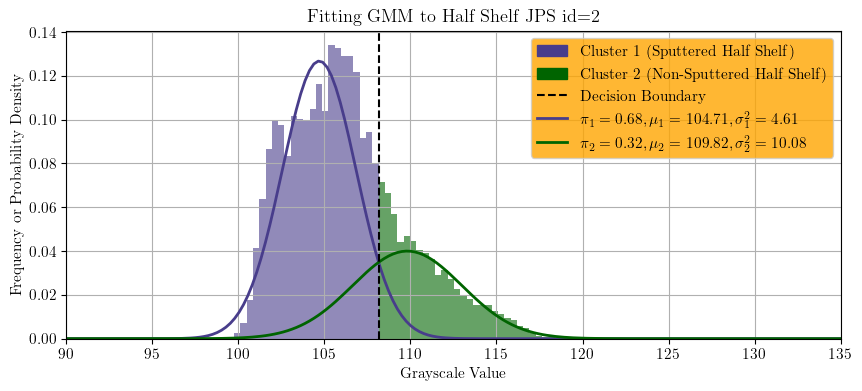

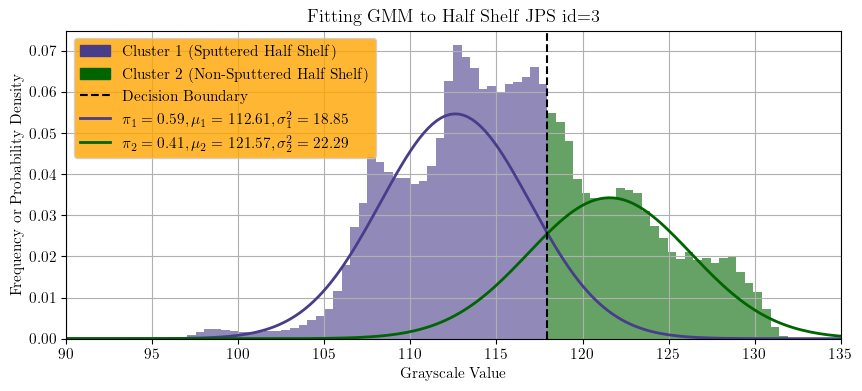

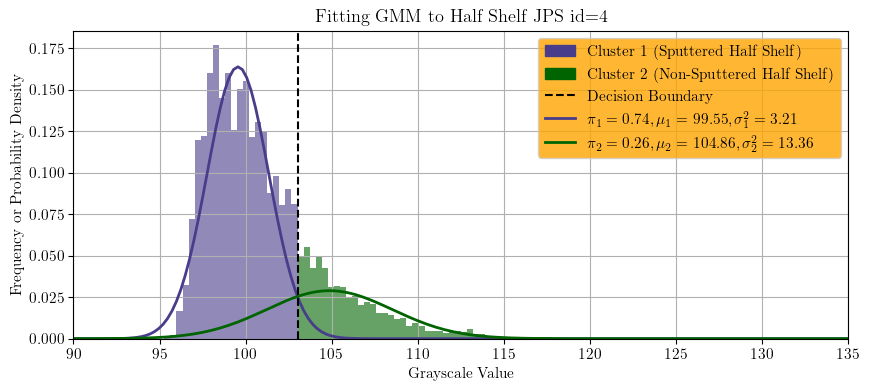

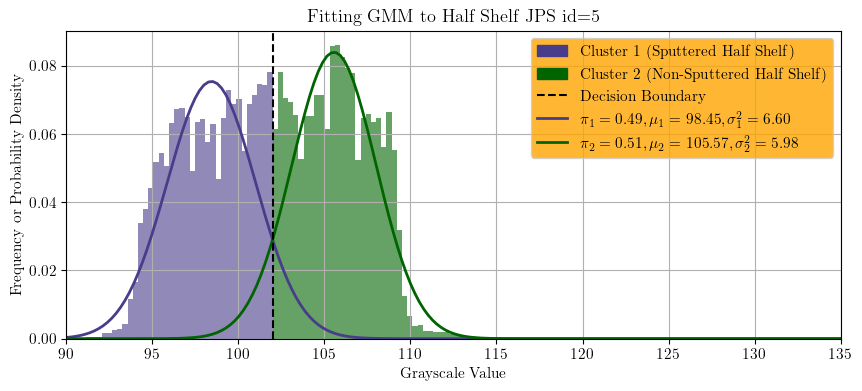

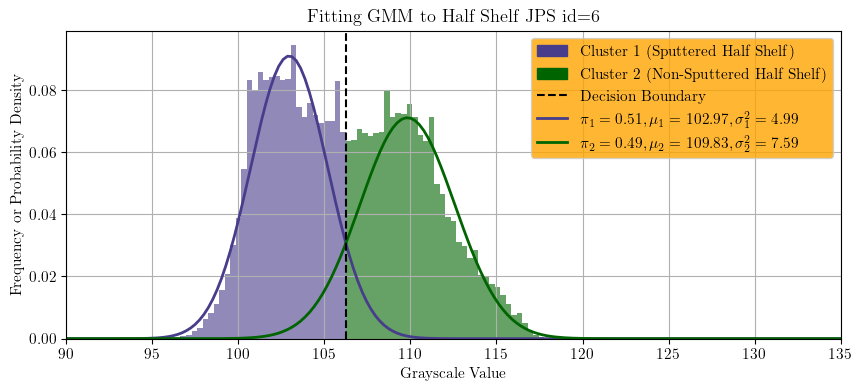

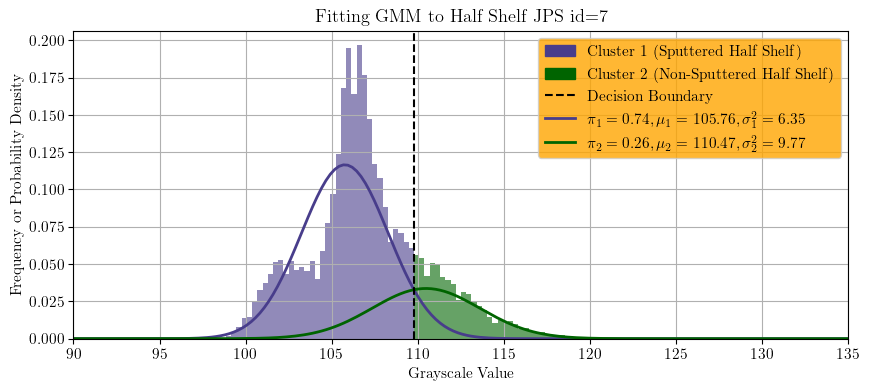

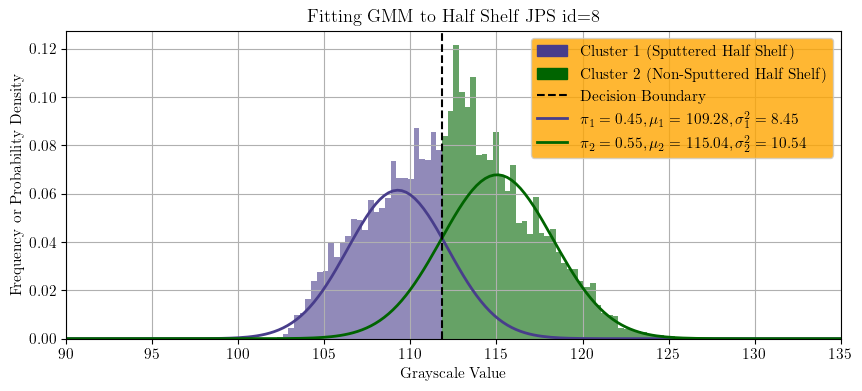

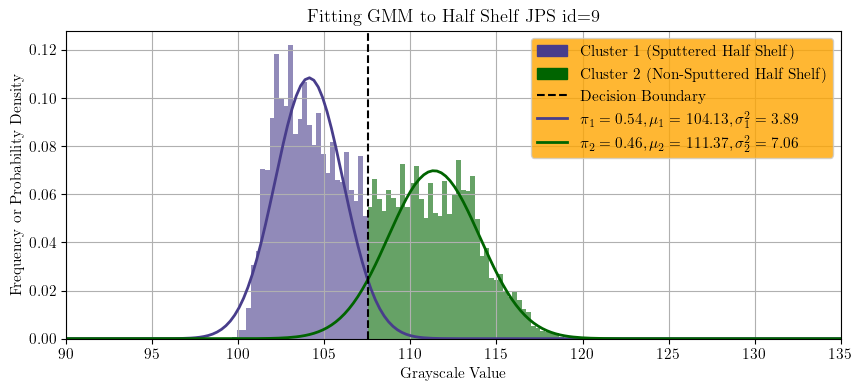

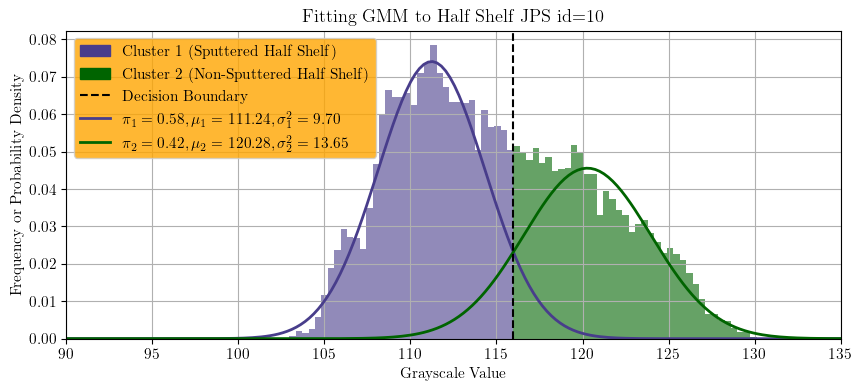

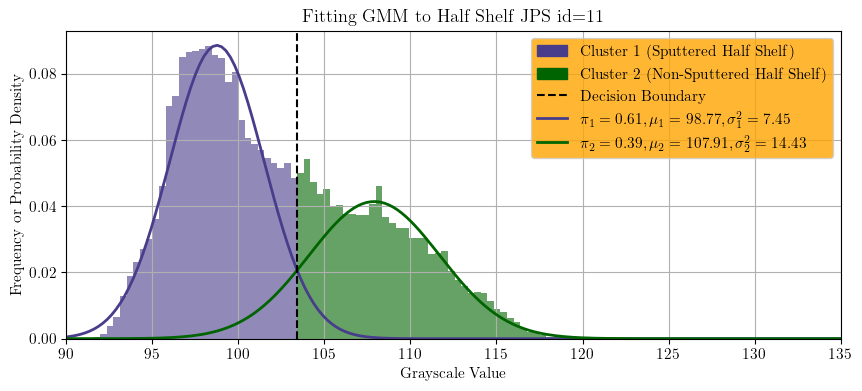

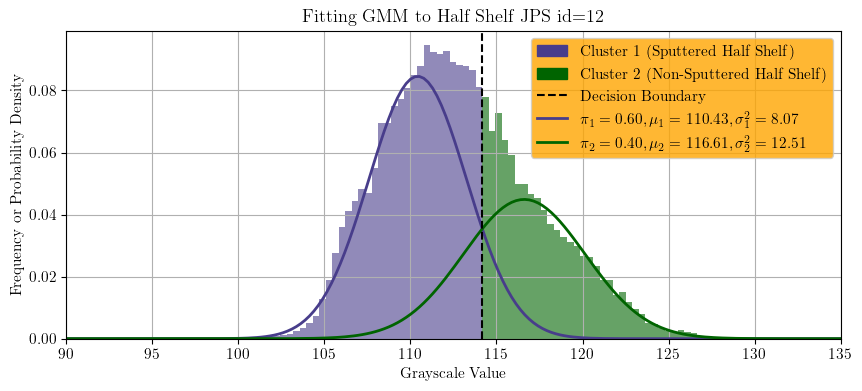

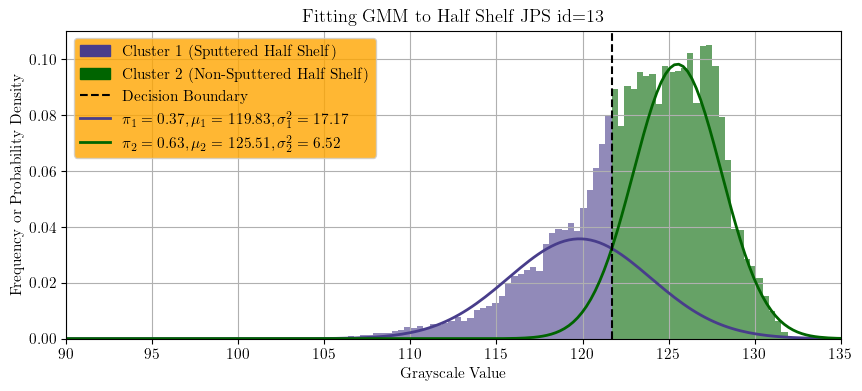

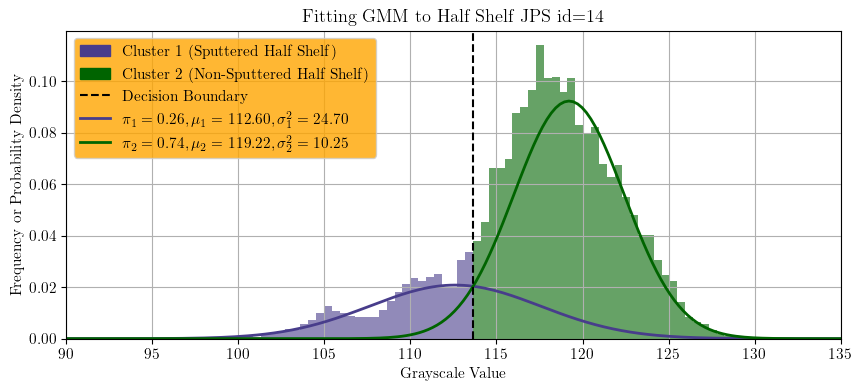

In [8]:
colors = ['darkslateblue', 'darkgreen']

for i in range(len(priors)):
    d1,_=solve_gaussian_intersection(priors[i],means[i],np.sqrt(variance[i]))
    g1_patch = mpatches.Patch(color='darkslateblue', label='Cluster 1 (Sputtered Half Shelf)')
    g2_patch = mpatches.Patch(color='darkgreen', label='Cluster 2 (Non-Sputtered Half Shelf)')
    g3_patch = Line2D([0], [0], color='darkslateblue', lw=2, label=f'$\pi_1 = {priors[i][0]:.2f}, \mu_1={means[i][0]:.2f}, \sigma_1^2={variance[i][0]:.2f}$')
    g4_patch = Line2D([0], [0], color='darkgreen', lw=2, label=f'$\pi_2 = {priors[i][1]:.2f}, \mu_2={means[i][1]:.2f}, \sigma_2^2={variance[i][1]:.2f}$')
    dec_patch= Line2D([0], [0], color='black', label="Decision Boundary", linestyle='dashed')
    t = np.linspace(0,255, 1000)
    fig=plt.figure()
    fig.set_size_inches(10,4) 
    plt.title("Fitting GMM to Half Shelf JPS id="+str(i))
    y1=priors[i][0]*norm.pdf(t, means[i][0], np.sqrt(variance[i][0]))
    y2=priors[i][1]*norm.pdf(t, means[i][1], np.sqrt(variance[i][1]))
    bins=np.linspace(np.min(datas[i]),np.max(datas[i]),75)
    closest_index=np.argmin(np.abs(bins-d1))
    bins=bins+d1-bins[closest_index]
    counts, bins, patches =plt.hist(datas[i],bins=bins,density=True,alpha=0.6,color="darkgreen")
    for j in range(closest_index):
        patches[j].set_fc("darkslateblue")
    plt.plot(t, y1, color="darkslateblue", linewidth=2, label=f'$\pi_1 = {priors[i][0]:.2f}, \mu_1={means[i][0]:.2f}, \sigma_1^2={variance[i][0]:.2f}$')
    plt.plot(t, y2, color="darkgreen", linewidth=2, label=f'$\pi_2 = {priors[i][1]:.2f}, \mu_2={means[i][1]:.2f}, \sigma_2^2={variance[i][1]:.2f}$')
    plt.axvline(x = d1, color = 'black', linestyle='dashed')
    plt.xlabel("Grayscale Value")
    plt.ylabel("Frequency or Probability Density")
    plt.legend(handles=[g1_patch,g2_patch,dec_patch, g3_patch, g4_patch],frameon=True, facecolor="orange")
    plt.xlim(90, 135)
    plt.grid()
    plt.show()
    ax=fig.gca()
    ax.set_rasterized(True)
    fig.savefig('../export_graphs/half_shelf_gmm_'+str(i)+".eps", format="eps", dpi=1200, bbox_inches="tight")